In [1]:
from tensorflow.keras import backend as K
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# @title Mounting drive
from google.colab import drive
drive.mount('/content/drive/')

!unzip -q /content/drive/MyDrive/airbus-ship-detection.zip -d .

Mounted at /content/drive/


In [5]:
# @title RLE Decode

def rle_all_mask_decode(mask_rle_list, shape=(768, 768)):

    all_masks = np.zeros((shape[0] * shape[1],), dtype=np.uint8)

    for mask_rle in mask_rle_list:
        if isinstance(mask_rle, str):
            s = mask_rle.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
            starts -= 1
            ends = starts + lengths
            for lo, hi in zip(starts, ends):
                all_masks[lo:hi] = 1

    return all_masks.reshape(shape).T

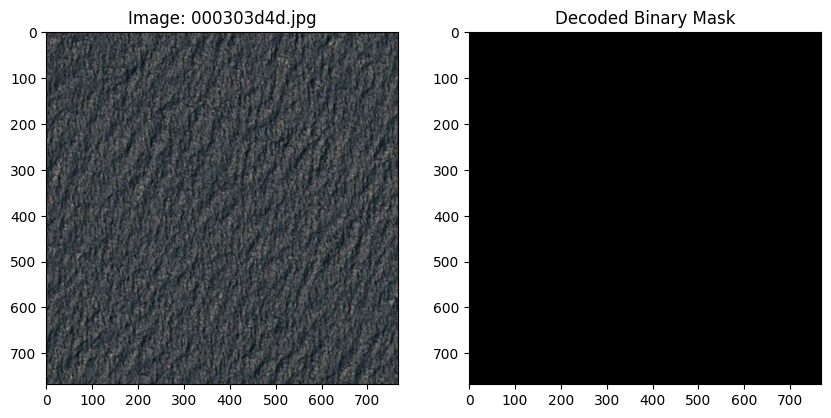

In [6]:
# @title RLE Decode test

df = pd.read_csv('train_ship_segmentations_v2.csv')

image_id = '000303d4d.jpg'
mask_rle_list = df.loc[df['ImageId'] == image_id, 'EncodedPixels'].tolist()

binary_mask = rle_all_mask_decode(mask_rle_list)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(f'train_v2/{image_id}'))
plt.title(f'Image: {image_id}')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Decoded Binary Mask')
plt.show()

In [25]:
# @title Dataset balancing and reducing number of entries

df = pd.read_csv('train_ship_segmentations_v2.csv')

# Filter for images with masks (EncodedPixels is not NaN)
masks_filtered = df.dropna(subset=['EncodedPixels'])

# Reduce the DataFrame to 40000 entries
balanced_df = masks_filtered.sample(40000, random_state=42)

Assuming to exploratory data analisys, dataset have unbalanced ratio of images with mask and empty mask

In [39]:
# @title Dataset generator class


class DataGen(keras.utils.Sequence):
    def __init__(self, df, batch_size=8, target_shape=(512, 512)):
        self.df = df
        self.target_shape = target_shape

        self.img_folder = "/content/train_v2"
        self.imgs = df['ImageId'].unique().tolist()

        self.batch_size = batch_size
        self.on_epoch_end()


    def __load__(self, img_name, mask_name):

        img = cv2.imread(os.path.join(self.img_folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.target_shape)

        mask = self.df.loc[self.df['ImageId'] == img_name, 'EncodedPixels'].tolist()
        mask = rle_all_mask_decode(mask)
        mask = cv2.resize(mask, self.target_shape, interpolation=cv2.INTER_NEAREST)

        img = img / 255.0
        mask = mask / 255.0

        return img, mask


    def __getitem__(self, index):

        imgs_names_batch = self.imgs[index*self.batch_size : (index+1)*self.batch_size]
        masks_names_batch = self.imgs[index*self.batch_size : (index+1)*self.batch_size]

        image_batch = []
        mask_batch  = []

        for nimg, nmask in zip(imgs_names_batch, masks_names_batch):
            img, mask = self.__load__(nimg, nmask)

            image_batch.append(img)
            mask_batch.append(mask)

        batch = np.array(image_batch), np.array(mask_batch)
        return batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.imgs)/float(self.batch_size)))

In [40]:
# @title Testing data generator

df = balanced_df
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_generator = DataGen(train_df)
val_generator = DataGen(val_df)

image, mask = train_generator.__getitem__(0)
print(image.shape, mask.shape)

(8, 512, 512, 3) (8, 512, 512)


In [45]:
# @title Defining U-Net model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Dropout(0.2)(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [46]:
# @title Dice Loss function

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)  # Subtract for loss minimization
    return bce_loss + dice_loss

In [47]:
# @title Compile model

model = build_unet(input_shape=(512, 512, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 512, 512, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 activation_90 (Activation)  (None, 512, 512, 64)         0         ['conv2d_95[0][0]']           
                                                                                                  
 batch_normalization_90 (Ba  (None, 512, 512, 64)         256       ['activation_90[0][0]']       
 tchNormalization)                                                                            

In [48]:
# @title Train model
batch_size = 16

ds_train = DataGen(train_df, batch_size)
ds_val = DataGen(val_df, batch_size)

print("Number of training batches:", len(ds_train))
print("Number of validation batches:",len(ds_val))


Number of training batches: 1392
Number of validation batches: 442


In [ ]:
train_imgs = "/content/train_v2"
train_steps = len(ds_train)

epochs = 20

history = model.fit(
    ds_train,
    validation_data=ds_val,
    steps_per_epoch=train_steps,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/20
1392/1392 [==============================] - 858s 609ms/step - loss: 1.3486 - accuracy: 0.9409 - val_loss: 1.0987 - val_accuracy: 0.9970
Epoch 2/20
1392/1392 [==============================] - 841s 604ms/step - loss: 1.0482 - accuracy: 0.9961 - val_loss: 1.0279 - val_accuracy: 0.9962
Epoch 3/20
1392/1392 [==============================] - 841s 604ms/step - loss: 1.0128 - accuracy: 0.9960 - val_loss: 1.0052 - val_accuracy: 0.9970
Epoch 4/20
1392/1392 [==============================] - 851s 611ms/step - loss: 1.0037 - accuracy: 0.9962 - val_loss: 1.0018 - val_accuracy: 0.9970
Epoch 5/20
1392/1392 [==============================] - 843s 605ms/step - loss: 1.0009 - accuracy: 0.9962 - val_loss: 0.9998 - val_accuracy: 0.9969
Epoch 6/20
1392/1392 [==============================] - 843s 606ms/step - loss: 0.9980 - accuracy: 0.9961 - val_loss: 0.9968 - val_accuracy: 0.9970
Epoch 7/20
1392/1392 [==============================] - 846s 608ms/step - loss: 0.9867 - accuracy: 0.9962 - val_

In [ ]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# @title Model evaluating and testing

def mean_iou(y_true, y_pred):
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()

  intersection = np.sum((y_true == 1) & (y_pred == 1))
  union = np.sum((y_true == 1) | (y_pred == 1))

  if union == 0:
    return 1.0 if np.all(y_true == y_pred) else 0.0

  iou = intersection / union
  return iou

In [ ]:
x, y = ds_val.__getitem__(0)

predictions = model.predict(x)
predictions = predictions > 0.5

loss, accuracy = model.evaluate(ds_val)
print("Evaluated accuracy:", accuracy)

IoU = mean_iou(y, predictions)
print("Mean IoU:", IoU)

In [ ]:
fig = plt.figure()
image_size = 512

ax = fig.add_subplot(2, 2, 1)
plt.title('Actual mask')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(2, 2, 2)
plt.title('Predicted mask')
ax.imshow(np.reshape(predictions[0]*255, (image_size, image_size)), cmap="gray")

fig = plt.figure()

ax = fig.add_subplot(2, 2, 3)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.imshow(np.reshape(predictions[1]*255, (image_size, image_size)), cmap="gray")

In [ ]:
model.save("U-Net.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
